# Where Should I Live?
This is a simple data science project to attempt to find the best location to live in Toronto. Data has been acquired from the City of TO website.

In [124]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
from sklearn import preprocessing
import seaborn as sns
import hvplot.pandas
import missingno as msno

In [125]:
neighborhood_data=gpd.read_file('Neighbourhoods.shp')

# Exploratory Data Analysis:

## Crime Data

In [126]:
# Load in the neighborhood crime data
neighborhood_crime_data=gpd.read_file('neighbourhood-crime-rates - 4326.geojson')

## Aesthetic Score

One of our main concerns in that of the Aesthetic Score of Apartment buildings

In [127]:
building_aesthetic_1=pd.read_csv('ApartmentBuildingEvaluation.csv')

Text(0.5, 1.0, 'Aesthetic Histogram of Apartment Buildings')

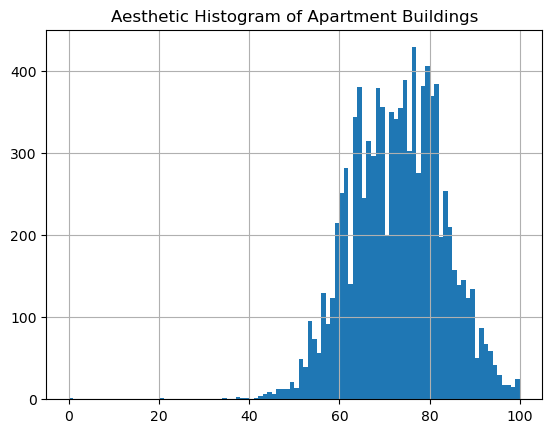

In [128]:
building_aesthetic_1['SCORE'].hist(bins=100)
plt.title('Aesthetic Histogram of Apartment Buildings')

In [129]:
print('Skew is: '+str(building_aesthetic_1['SCORE'].skew())[0:10])
print ('Mean is: '+str(building_aesthetic_1['SCORE'].mean())[0:10])

Skew is: -0.1022508
Mean is: 72.4249748


## Missing Data

Let's take a look at the data that has been recorded with each apartment

<AxesSubplot:>

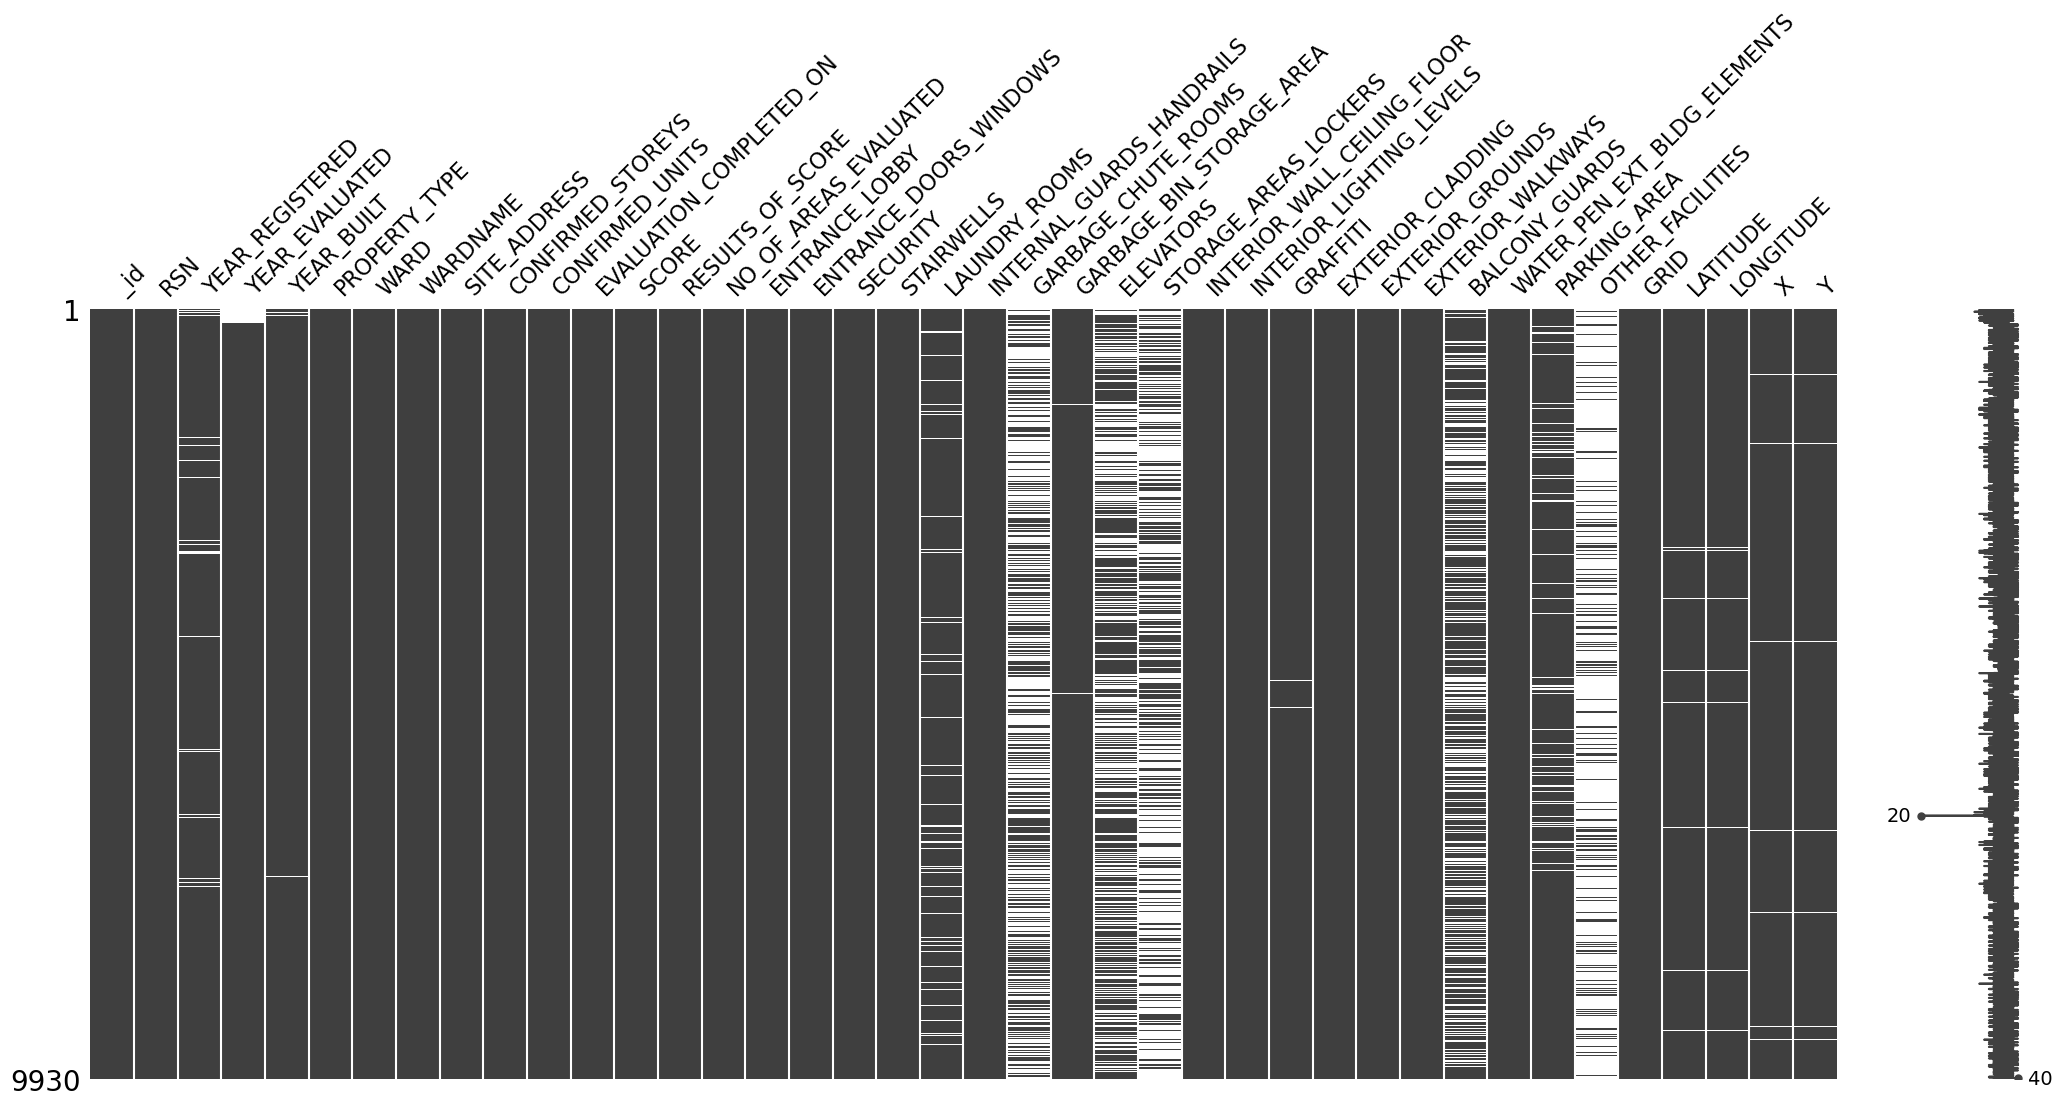

In [130]:
msno.matrix(building_aesthetic_1)

Seems like missing data is fairly normal for these types of datasets. Let's check the mean number of areas evaluated:

In [131]:
building_aesthetic_1['NO_OF_AREAS_EVALUATED'].mean(axis=0)

17.155287009063443

We see that alot of data is missing.Specifically the average number of areas evaulated is only 17/20. Check to see if the score is simply manifactured from the mean aesthetic scores (column 15-35):

In [132]:
calculated_score=np.round(
       (building_aesthetic_1 # Load building aesthetic data
       .iloc[:,15:35]    # All Columns from 15 to 35
       .mean(axis=1)     # Average the aesthetic score fields
       /5)               # score is a 1-5 scale
       *100)             # multiply by 100 to get percentage
calculated_score

0       53.0
1       80.0
2       85.0
3       93.0
4       65.0
        ... 
9925    76.0
9926    62.0
9927    70.0
9928    66.0
9929    68.0
Length: 9930, dtype: float64

In [133]:
building_aesthetic_1['SCORE']

0       53
1       80
2       85
3       93
4       65
        ..
9925    76
9926    62
9927    70
9928    66
9929    68
Name: SCORE, Length: 9930, dtype: int64

Lets only pass through data that has scores matching to their calculated mean score to ensure that we don't get outliers:

In [134]:
building_aesthetic=building_aesthetic_1[building_aesthetic_1['SCORE'].astype('float64')==calculated_score]

Text(0.5, 1.0, 'Aesthetic Score Out of 100')

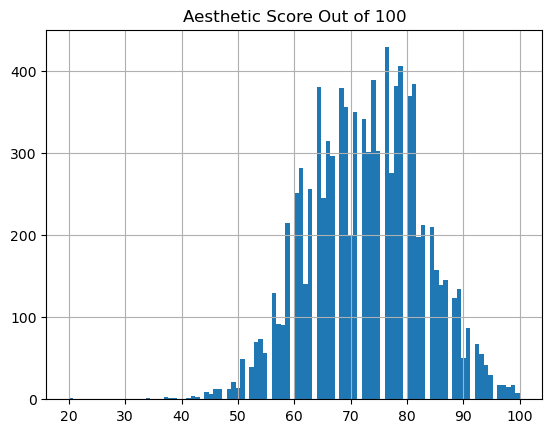

In [135]:
building_aesthetic['SCORE'].hist(bins=100)
plt.title('Aesthetic Score Out of 100')

In [136]:
print('Skew is: '+str(building_aesthetic['SCORE'].skew())[0:10])
print ('Mean is: '+str(building_aesthetic['SCORE'].mean())[0:10])

Skew is: -0.0757249
Mean is: 72.5690082


### Group by Neighborhood

Group the Aesthtics of the Buildings in with the neighborhood data of the nighborhood crime dataset

In [137]:
# Here we convert a df into a gdf
building_aesthetic_gdf=gpd.GeoDataFrame(
    building_aesthetic,geometry=gpd.points_from_xy(building_aesthetic['LONGITUDE'],
                                                   building_aesthetic['LATITUDE']))

In [138]:
# Average Out the Aesthetic Scores of the Neighborhoods
Average_Aesthetic=[]
Average_Aesthetic_std=[]
Apartment_Counts=[]
for row,hood in enumerate(neighborhood_crime_data.iloc):
    # Calculate the Average Aesthetic per neighborhood
    Average_Aesthetic.append(np.mean(building_aesthetic_gdf[building_aesthetic_gdf['geometry'].within(hood['geometry'])]['SCORE']))
    Average_Aesthetic_std.append(np.std(building_aesthetic_gdf[building_aesthetic_gdf['geometry'].within(hood['geometry'])]['SCORE']))
    Apartment_Counts.append(building_aesthetic_gdf['geometry'].within(hood['geometry']).sum())

In [139]:
# Add the Average Aesthetic Scores to the neihborhood crime data
neighborhood_crime_data['Average Aesthetic']=Average_Aesthetic
neighborhood_crime_data['Average Aesthetic std']=Average_Aesthetic_std
neighborhood_crime_data['Num of Apartment (RentSafeTO)']=Apartment_Counts

## Home Prices

Note that the latest available home prices are from 2011 which are unfortunately very much outdated so some caution must be taken.

In [140]:
home_prices=pd.read_excel('wellbeing-toronto-housing.xlsx','RawDataRef_2011')

In [141]:
neighboorhood_2011_price=[]
for neighborhood_crime_instance in neighborhood_crime_data.iloc:
  try:
    neighboorhood_2011_price.append((home_prices[home_prices['Neighbourhood']==neighborhood_crime_instance['HoodName']]['Home Prices']).values[0])
    # Some Neighborhoods exist in the neighborhood crime set but not in the home prices
  except: 
    neighboorhood_2011_price.append(np.nan)

In [142]:
neighborhood_crime_data['Home Prices']=neighboorhood_2011_price

Text(0.5, 1.0, 'Histogram of 2011 Home Prices')

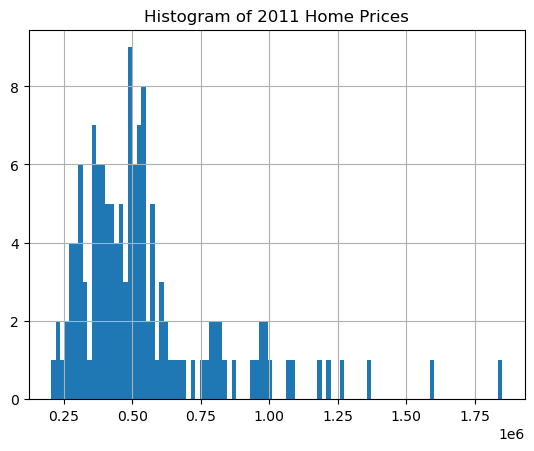

In [143]:
neighborhood_crime_data['Home Prices'].hist(bins=100)
plt.title('Histogram of 2011 Home Prices')

In [144]:
neighborhood_crime_data['Home Prices'].skew()

1.9773291975112226

In [145]:
print('Average Home Price in Toronto (2011): ' +str(neighborhood_crime_data['Home Prices'].mean()))
print('Median Home Price in Toronto (2011): ' +str(neighborhood_crime_data['Home Prices'].median()))

Average Home Price in Toronto (2011): 548664.6376811594
Median Home Price in Toronto (2011): 490972.0


# Data Analysis and Visualization:

## Aesthetics

<AxesSubplot:title={'center':'Apartment Aestethic Plotted'}, xlabel='LONGITUDE', ylabel='LATITUDE'>

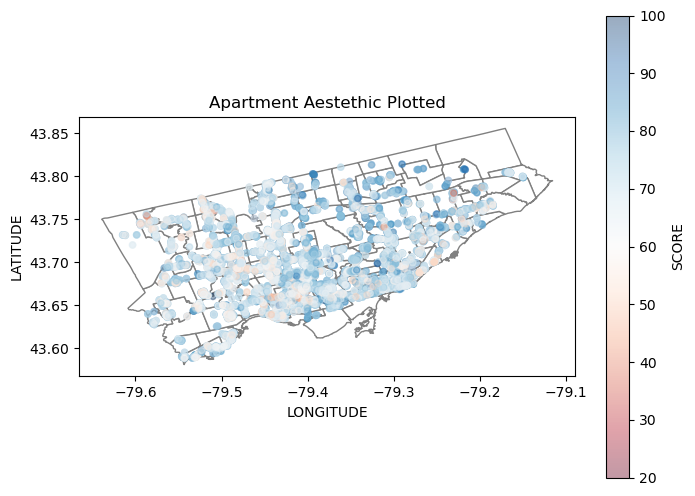

<Figure size 640x480 with 0 Axes>

In [146]:
#pd.options.plotting.backend = 'matplotlib'
fig, ax = plt.subplots(figsize=(8,6))
plt.figure()
neighborhood_data.plot(facecolor='white',
                         edgecolor='grey',
                         ax=ax) 

building_aesthetic.plot(x='LONGITUDE',
                      y='LATITUDE', 
                      kind='scatter',
                      c='SCORE', 
                      cmap='RdBu',
                      alpha=0.4,ax=ax,
                       title='Apartment Aestethic Plotted')




In [147]:
# Create an interactive plot of the Average Aesthetic of the buildings per neighborhood
neighborhood_crime_data.hvplot(
    c='Average Aesthetic',
    hover_cols=['HoodName'],
    cmap='Blues',
    title='Average Aesthetic Score (-/100) of Apartments (2021)'
)

:Polygons   [x,y]   (Average Aesthetic,HoodName)

In [148]:
# Interactively plot the Standard Deviation of the Apartmnet Aesthetic
# Higher Standard Deviation shows that the buildings vary significantly within
# the neighborhood
neighborhood_crime_data.hvplot(
    c='Average Aesthetic std',
    hover_cols=['HoodName'],
    cmap='Reds',
    title='Standard Deviation of Apartment Aesthetic Score 2021'
)

:Polygons   [x,y]   (Average Aesthetic std,HoodName)

In [149]:
# Plot the Number of Apartments Available in a certain neighborhood
neighborhood_crime_data.hvplot(
    c='Num of Apartment (RentSafeTO)',
    hover_cols=['HoodName'],
    cmap='Greys',
    title='Number of Official Apartments Available'
)

:Polygons   [x,y]   (Num of Apartment (RentSafeTO),HoodName)

In [178]:
neighborhood_crime_data.sort_values(['Num of Apartment (RentSafeTO)'],ascending=False)

_id  OBJECTID                           HoodName  HoodID  \
91    92        92               Downsview-Roding-CFB      26   
15    16        16                     South Parkdale      85   
81    82        82                Englemount-Lawrence      32   
4      5         5                Stonegate-Queensway      16   
10    11        11                 Humewood-Cedarvale     106   
..   ...       ...                                ...     ...   
134  135       135                           Milliken     130   
126  127       127                            Steeles     116   
71    72        72                     Highland Creek     134   
21    22        22             Centennial Scarborough     133   
116  117       117  Bridle Path-Sunnybrook-York Mills      41   

     F2021_Population_Projection  Assault_2014  Assault_2015  Assault_2016  \
91                         39602           330           357           359   
15                         24635           184           219           220   
81                         25575            80            84           133   
4                          27838            91            74            78   
10                         16078            34            47            51   
..                           ...           ...           ...           ...   
134                        29625            72            95            91   
126                        27319            44            35            45   
71                         14240            52            50            73   
21                         14868            52            38            49   
116                        11376            17            29            18   

     Assault_2017  Assault_2018  ...  TheftfromMotorVehicle_Rate2020  \
91            408           426  ...                        600.2925   
15            218           203  ...                        165.2073   
81            107            97  ...                        275.0209   
4              98            86  ...                        353.8854   
10             39            44  ...                        391.0685   
..            ...           ...  ...                             ...   
134            83            74  ...                        288.0066   
126            43            31  ...                         78.0350   
71             68            50  ...                        329.9146   
21             47            46  ...                        272.6281   
116            26            32  ...                        356.4248   

     TheftfromMotorVehicle_Rate2021  \
91                       429.271249   
15                       202.963264   
81                       242.424242   
4                        204.756089   
10                       230.128125   
..                              ...   
134                      232.911392   
126                      102.492771   
71                       168.539326   
21                       242.130751   
116                      105.485232   

                                              geometry  Average Aesthetic  \
91   POLYGON ((-79.50782 43.71776, -79.50852 43.717...          70.540299   
15   POLYGON ((-79.42776 43.62979, -79.42947 43.630...          68.973064   
81   POLYGON ((-79.43853 43.70586, -79.43853 43.705...          70.596154   
4    POLYGON ((-79.49261 43.64744, -79.49276 43.647...          70.419492   
10   POLYGON ((-79.41847 43.68363, -79.41911 43.683...          71.357466   
..                                                 ...                ...   
134  POLYGON ((-79.24306 43.81297, -79.24431 43.812...          86.000000   
126  POLYGON ((-79.34130 43.81565, -79.33986 43.816...          84.000000   
71   POLYGON ((-79.17525 43.78021, -79.17533 43.780...                NaN   
21   POLYGON ((-79.14509 43.76637, -79.14506 43.767...                NaN   
116  POLYGON ((-79.39006 43.72768, -79.39015 43.728...                NaN   

     Average Aesthetic std  

## Crime

Let's load in the crime data and see if it relates to building neighborhood aestethic.

In [150]:
crime_columns=neighborhood_crime_data[['TheftOver_Rate2021',
                                           'Assault_Rate2021',
                                           'BreakAndEnter_Rate2021',
                                           'Robbery_Rate2021',
                                           'TheftfromMotorVehicle_Rate2021',
                                           'Average Aesthetic',
                                           'F2021_Population_Projection',
                                           'Num of Apartment (RentSafeTO)']]

In [151]:
crime_columns.corr()

TheftOver_Rate2021  Assault_Rate2021  \
TheftOver_Rate2021                        1.000000          0.482038   
Assault_Rate2021                          0.482038          1.000000   
BreakAndEnter_Rate2021                    0.552507          0.685232   
Robbery_Rate2021                          0.462077          0.770923   
TheftfromMotorVehicle_Rate2021            0.625323          0.367203   
Average Aesthetic                        -0.083563         -0.305836   
F2021_Population_Projection               0.135759          0.151098   
Num of Apartment (RentSafeTO)             0.030115          0.216280   

                                BreakAndEnter_Rate2021  Robbery_Rate2021  \
TheftOver_Rate2021                            0.552507          0.462077   
Assault_Rate2021                              0.685232          0.770923   
BreakAndEnter_Rate2021                        1.000000          0.628461   
Robbery_Rate2021                              0.628461          1.000000   
TheftfromMotorVehicle_Rate2021                0.410704          0.384722   
Average Aesthetic                            -0.160336         -0.156348   
F2021_Population_Projection                   0.076213          0.128728   
Num of Apartment (RentSafeTO)                 0.117017          0.097969   

                                TheftfromMotorVehicle_Rate2021  \
TheftOver_Rate2021                                    0.625323   
Assault_Rate2021                                      0.367203   
BreakAndEnter_Rate2021                                0.410704   
Robbery_Rate2021                                      0.384722   
TheftfromMotorVehicle_Rate2021                        1.000000   
Average Aesthetic                                    -0.103026   
F2021_Population_Projection                           0.029211   
Num of Apartment (RentSafeTO)                         0.000087   

                                Average Aesthetic  \
TheftOver_Rate2021                      -0.083563   
Assault_Rate2021                        -0.305836   
BreakAndEnter_Rate2021                  -0.160336   
Robbery_Rate2021                        -0.156348   
TheftfromMotorVehicle_Rate2021          -0.103026   
Average Aesthetic                        1.000000   
F2021_Population_Projection              0.265270   
Num of Apartment (RentSafeTO)           -0.178328   

                                F2021_Population_Projection  \
TheftOver_Rate2021                                 0.135759   
Assault_Rate2021                                   0.151098   
BreakAndEnter_Rate2021                             0.076213   
Robbery_Rate2021                                   0.128728   
TheftfromMotorVehicle_Rate2021                     0.029211   
Average Aesthetic                                  0.265270   
F2021_Population_Projection                        1.000000   
Num of Apartment (RentSafeTO)                      0.225357   

                                Num of Apartment (RentSafeTO)  
TheftOver_Rate2021                                   0.030115  
Assault_Rate2021                                     0.216280  
BreakAndEnter_Rate2021                               0.117017  
Robbery_Rate2021                                     0.097969  
TheftfromMotorVehicle_Rate2021                       0.000087  
Average Aesthetic                                   -0.178328  
F2021_Population_Projection                          0.225357  
Num of Apartment (RentSafeTO)                        1.000000

Text(0.5, 1.0, 'Number of Apartments as of 2021 and Neighborhood Population Correlating to Crime Rates')

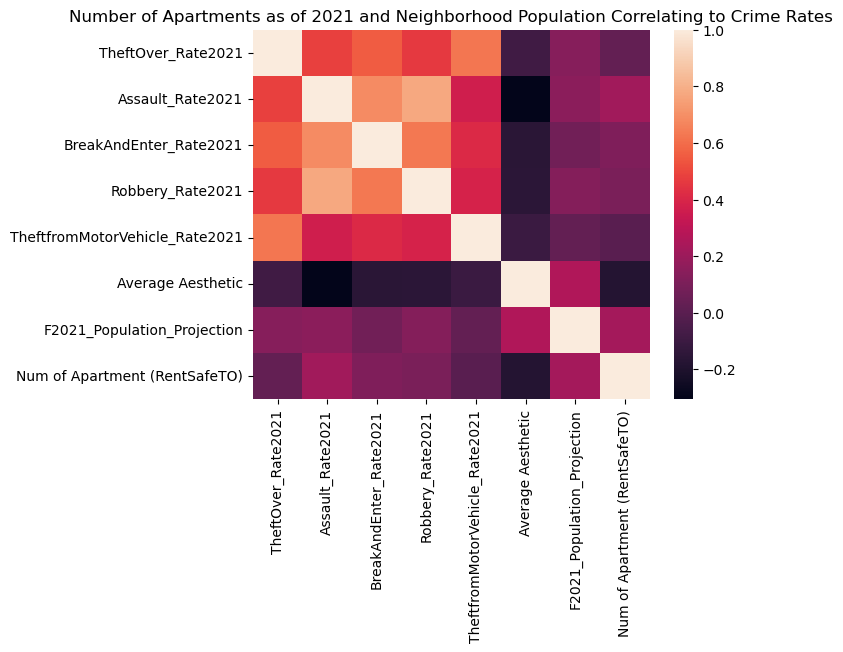

In [152]:
sns.heatmap(crime_columns.corr())
plt.title('Number of Apartments as of 2021 and Neighborhood Population Correlating to Crime Rates')

From this heatmap we can see a few interesting trends. For one, we see a slight negative correlation between the number of apartments and the average aesthetic of the buildings. We also see that the assault rate is somewhat correlated with the number of people in a neighborhood and the number of apartments in the neihborhood. As expected we see a negative correlation between the aesthetics of the neighborhood and the various crime rates.

### Assault Rate

In [153]:
neighborhood_crime_data.hvplot(
    c='Assault_Rate2021',
    hover_cols=['HoodName'],
    cmap='Reds',
    legend=True,
    title='Assault Rate 2021 (-/100,000 ppl)'
)

:Polygons   [x,y]   (Assault_Rate2021,HoodName)

In [154]:
# Output top highest Assault Rates of 2021
neighborhood_crime_data.sort_values('Assault_Rate2021',ascending=False)[['HoodName','Assault_Rate2021']].iloc[0:3]

HoodName  Assault_Rate2021
130              Moss Park          2569.646
22   Church-Yonge Corridor          2367.415
51    Kensington-Chinatown          1854.226

In [155]:
# Output the lowest Assault Rates of 2021
neighborhood_crime_data.sort_values('Assault_Rate2021',ascending=True)[['HoodName','Assault_Rate2021']].iloc[0:3]

HoodName  Assault_Rate2021
54      Forest Hill South          125.6281
135         Pleasant View          152.4658
114  Bedford Park-Nortown          153.8692

The Latest Dataset shows that Moss Park, Church-Yong Corridor and Kensington-Chinatown have the highest rates of Assault while Forest Hill osuth, Pleasant View and Bedfor Park-Nortown have the lowest rates of assault

### Break and Enter Rate 2021

In [156]:
neighborhood_crime_data.hvplot(
    c='BreakAndEnter_Rate2021',
    hover_cols=['HoodName'],
    cmap='Reds',
    legend=True,
    title='Break And Enter Rates 2021 (-/100,000 ppl)'
)

:Polygons   [x,y]   (BreakAndEnter_Rate2021,HoodName)

## Home Prices

Three Most Expensive Neighborhoods:

In [157]:
neighborhood_crime_data.sort_values('Home Prices',ascending=False)[['HoodName','Home Prices']].iloc[0:3]

HoodName  Home Prices
116  Bridle Path-Sunnybrook-York Mills    1849084.0
54                   Forest Hill South    1585984.0
17                St.Andrew-Windfields    1363202.0

Three Cheapest Neighborhoods:

In [158]:
neighborhood_crime_data.sort_values('Home Prices',ascending=True)[['HoodName','Home Prices']].iloc[0:3]

HoodName  Home Prices
25   Flemingdon Park     204104.0
78  Elms-Old Rexdale     233832.0
94       Black Creek     235143.0

In [159]:
neighborhood_crime_data.hvplot(
    c='Home Prices',
    hover_cols=['HoodName'],
    cmap='Blues_r',
    title='Price of Homes (2011)'
)
#plt.title('Home Prices 2011')

:Polygons   [x,y]   (Home Prices,HoodName)

In [160]:
neighborhood_crime_data['Home Prices']=neighboorhood_2011_price
neighborhood_crime_data.hvplot(
    c='Home Prices',
    hover_cols=['HoodName'],
    cmap='Reds',
    legend=True,
    title='Price of Homes (2011)'
)
#plt.title('Home Prices 2011')

:Polygons   [x,y]   (Home Prices,HoodName)

Correlating Crime Rate to Housing Prices

In [161]:
# We want to correlate 2011 Housing Prices to Crime Rates so we will look at 
# 2014 Crime Rates
neighborhood_crime_2014=neighborhood_crime_data[['Assault_Rate2014',
                                            'AutoTheft_Rate2014',
                                            'BreakAndEnter_Rate2014',
                                            'Robbery_Rate2014',
                                            'TheftOver_Rate2014',
                                            'Homicide_Rate2014',
                                            'Shooting_Rate2014',
                                            'TheftfromMotorVehicle_Rate2014',
                                            'Home Prices']]

In [162]:
neighborhood_crime_2014.corr()

Assault_Rate2014  AutoTheft_Rate2014  \
Assault_Rate2014                        1.000000            0.142481   
AutoTheft_Rate2014                      0.142481            1.000000   
BreakAndEnter_Rate2014                  0.466618            0.150250   
Robbery_Rate2014                        0.801809            0.198850   
TheftOver_Rate2014                      0.482530            0.364447   
Homicide_Rate2014                      -0.119628           -0.180073   
Shooting_Rate2014                       0.251362            0.068576   
TheftfromMotorVehicle_Rate2014          0.510289            0.248661   
Home Prices                            -0.363835           -0.213506   

                                BreakAndEnter_Rate2014  Robbery_Rate2014  \
Assault_Rate2014                              0.466618          0.801809   
AutoTheft_Rate2014                            0.150250          0.198850   
BreakAndEnter_Rate2014                        1.000000          0.508014   
Robbery_Rate2014                              0.508014          1.000000   
TheftOver_Rate2014                            0.446466          0.350109   
Homicide_Rate2014                             0.246833         -0.212847   
Shooting_Rate2014                            -0.097103          0.246227   
TheftfromMotorVehicle_Rate2014                0.541180          0.460046   
Home Prices                                   0.300702         -0.285253   

                                TheftOver_Rate2014  Homicide_Rate2014  \
Assault_Rate2014                          0.482530          -0.119628   
AutoTheft_Rate2014                        0.364447          -0.180073   
BreakAndEnter_Rate2014                    0.446466           0.246833   
Robbery_Rate2014                          0.350109          -0.212847   
TheftOver_Rate2014                        1.000000          -0.208544   
Homicide_Rate2014                        -0.208544           1.000000   
Shooting_Rate2014                         0.022248          -0.040478   
TheftfromMotorVehicle_Rate2014            0.479068           0.003220   
Home Prices                               0.085530           0.055909   

                                Shooting_Rate2014  \
Assault_Rate2014                         0.251362   
AutoTheft_Rate2014                       0.068576   
BreakAndEnter_Rate2014                  -0.097103   
Robbery_Rate2014                         0.246227   
TheftOver_Rate2014                       0.022248   
Homicide_Rate2014                       -0.040478   
Shooting_Rate2014                        1.000000   
TheftfromMotorVehicle_Rate2014           0.013256   
Home Prices                             -0.201982   

                                TheftfromMotorVehicle_Rate2014  Home Prices  
Assault_Rate2014                                      0.510289    -0.363835  
AutoTheft_Rate2014                                    0.248661    -0.213506  
BreakAndEnter_Rate2014                                0.541180     0.300702  
Robbery_Rate2014                                      0.460046    -0.285253  
TheftOver_Rate2014                                    0.479068     0.085530  
Homicide_Rate2014                                     0.003220     0.055909  
Shooting_Rate2014                                     0.013256    -0.201982  
TheftfromMotorVehicle_Rate2014                        1.000000     0.013490  
Home Prices                                           0.013490     1.000000

Text(0.5, 1.0, 'Home Prices 2011 Correlated to Various 2014 Crime Rates')

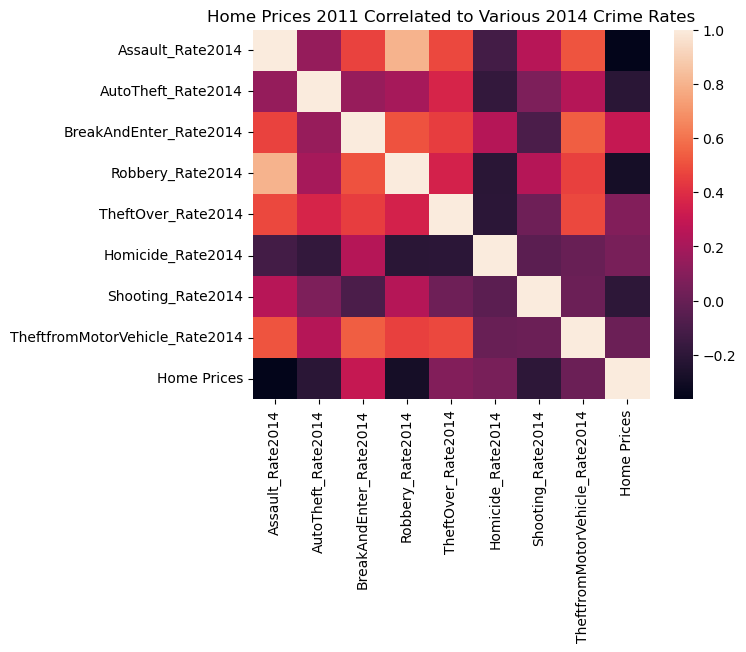

In [163]:
sns.heatmap(neighborhood_crime_2014.corr())
plt.title('Home Prices 2011 Correlated to Various 2014 Crime Rates')

Interestingly enough for the most part crime rates are either not associated with housing prices or have a negative correlation with housing prices, however break and enters have a positive correlation with the home prices of a neighborhood.

# Prediction

Only Crime Rate Predictions can be made due to the lack of temporal data with the other property attributes (Aesthetics, Num of Apartments, Prices)

In [164]:
Assault_Trends=neighborhood_crime_data[['HoodName',
                                 'Assault_Rate2014',
                                 'Assault_Rate2015',
                                 'Assault_Rate2016',
                                 'Assault_Rate2017',
                                 'Assault_Rate2018',
                                 'Assault_Rate2019',
                                 'Assault_Rate2020',
                                 'Assault_Rate2021']]

In [165]:
# Perform Linear Regression Predictions on the Crime Rate/ Neighborhood
from sklearn.linear_model import LinearRegression
years=[[2014],[2015],[2016],[2017],[2018],[2019],[2020],[2021]]
model=LinearRegression()
R_2_scores=[]
model_intercepts=[]
model_coeff=[]

for hood in Assault_Trends.iloc:
  hoodname=hood['HoodName']
  y_data=hood[1:].values
  model.fit(years,y_data)
  R_2_scores.append(model.score(years,y_data))
  model_coeff.append(model.coef_[0])
  model_intercepts.append(model.intercept_)
  y_pred=model.predict(years)
#   plt.scatter(years,y_data,color='black')
#   plt.plot(years,y_pred,color='blue')
#   plt.title('Crime Rate Increase Prediction for:'+ hoodname+' with R^2 = '+ str(model.score(years,y_data))[0:5])
#   plt.ylabel('Assault Rate/100,000 people')
#   plt.xlabel('Year')
#   plt.show()

In [166]:
# Add this to the neighborhood crime data
neighborhood_crime_data['Assualts, Linear Fit Slope']=model_coeff
neighborhood_crime_data['Assualts, Linear Fit Intercept']=model_intercepts
neighborhood_crime_data['Assualts, Linear Fit Score']=R_2_scores

In [167]:
#plot The expected Crime Rate Using a scorer greater than 0.2
neighborhood_crime_high_scores=neighborhood_crime_data[neighborhood_crime_data['Assualts, Linear Fit Score']>0.2]
neighborhood_crime_high_scores.hvplot(
    c='Assualts, Linear Fit Slope',
    hover_cols=['HoodName','Assualts, Linear Fit Score'],
    cmap='seismic',
    legend=True,
    title='Rising Rates of Assault /100,000 People')
#title('Rising or Declining Rates of Assault /100,000 People')

:Polygons   [x,y]   (Assualts, Linear Fit Slope,HoodName,Assualts, Linear Fit Score)

Places with Worsening Crime:

In [168]:
neighborhood_crime_high_scores.sort_values('Assualts, Linear Fit Slope',ascending=False)[['HoodName','Assualts, Linear Fit Slope','Assualts, Linear Fit Score']].iloc[0:3]

HoodName  Assualts, Linear Fit Slope  \
130              Moss Park                  167.811738   
22   Church-Yonge Corridor                   92.890476   
72     North St.James Town                   73.508545   

     Assualts, Linear Fit Score  
130                    0.754164  
22                     0.605795  
72                     0.762592

Places with Lessening Crime:

In [169]:
neighborhood_crime_high_scores.sort_values('Assualts, Linear Fit Slope',ascending=True)[['HoodName','Assualts, Linear Fit Slope','Assualts, Linear Fit Score']].iloc[0:3]

HoodName  Assualts, Linear Fit Slope  \
60           University                 -115.718583   
93  Bay Street Corridor                 -105.437595   
48    O'Connor-Parkview                  -46.840818   

    Assualts, Linear Fit Score  
60                    0.600159  
93                    0.234307  
48                    0.771069

The Places with a rapidly lowering crime rates (Assaults) are University, Bay Street Corridor, O'Connor-Parkview and Kennedy Park.
The Neighborhoods with the most rapidily rising crime rates (Assaults) are Moss Park, Church-Yong Corridor and North St. James Town